<a href="https://colab.research.google.com/github/Ksenia-90/Data_analysis_algorithms/blob/lesson_5/lesson_5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Урок 5. Случайный лес**

1.Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

2.Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

3.Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4.(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [837]:
import numpy as np
import random
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import math

%matplotlib inline

In [838]:
# сгенерируем данные, представляющие собой 100 объектов с 2мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

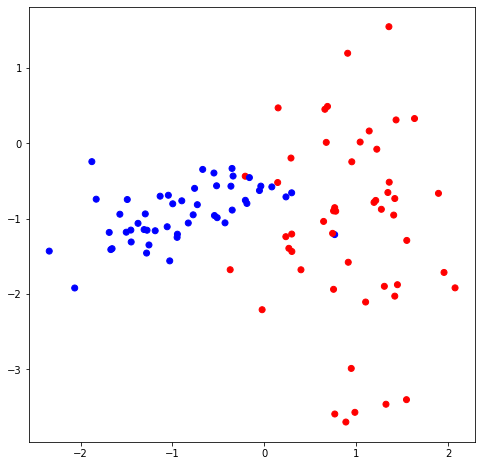

In [839]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [840]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [841]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [842]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [843]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction       

In [844]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p **2
        
    return impurity

In [845]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [846]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [847]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [848]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [849]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [850]:
#Добавим фукцию случайного формирования леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [851]:
 #Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [852]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [853]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [854]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


In [855]:
# Визуализируем дерево на графике

def plot_forest(forest, train_data, test_data):
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [856]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [857]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [858]:
def classification_error(p):
   return 1 - np.max([p, 1 - p])

In [859]:
c_err = [classification_error(i) for i in train_data]


**Лес из одного дерева**

In [860]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [861]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [862]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143


In [863]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 80.000


In [864]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 1, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print(forest.oob_score_)

Score:  0.9571428571428572
0.6714285714285714


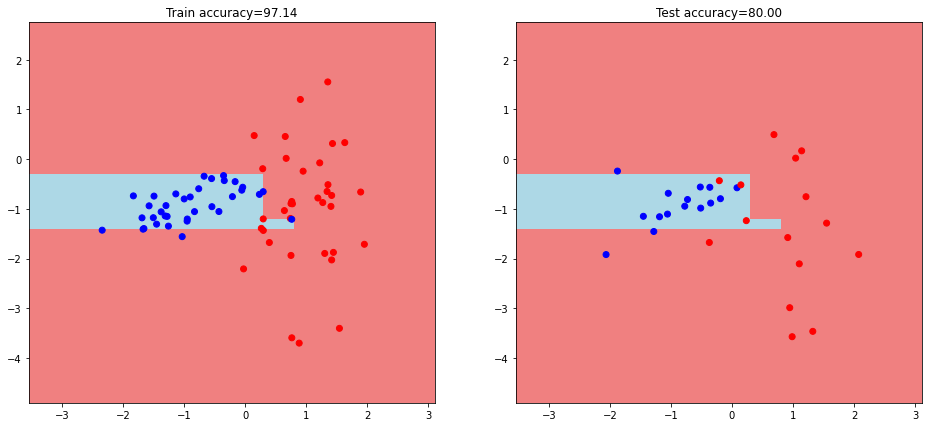

In [865]:
plot_forest(my_forest_1, train_data, test_data)

**Лес из 3-х деревьев**

In [866]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [867]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [868]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.143


In [869]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 80.000


In [870]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 3, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  0.9714285714285714
oob_score_ 0.8142857142857143


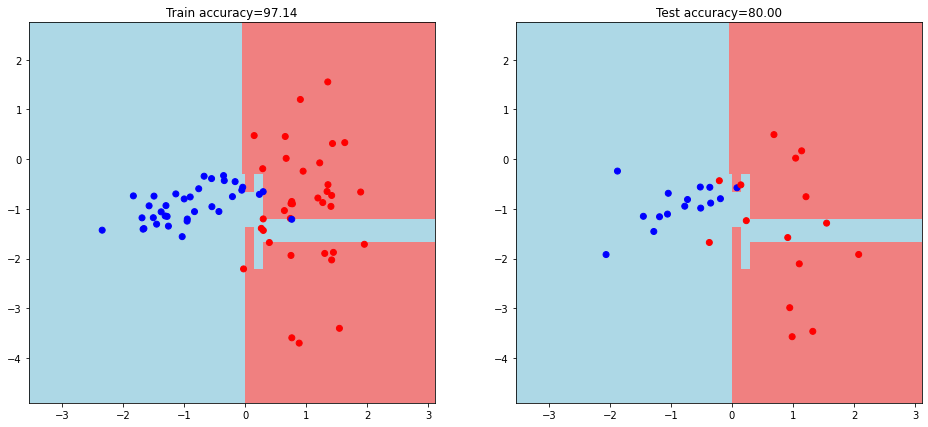

In [871]:
plot_forest(my_forest_3, train_data, test_data)

**Лес из 50 деревьев**

In [872]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [873]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [874]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [875]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 86.667


In [876]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 50, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  1.0
oob_score_ 0.9285714285714286


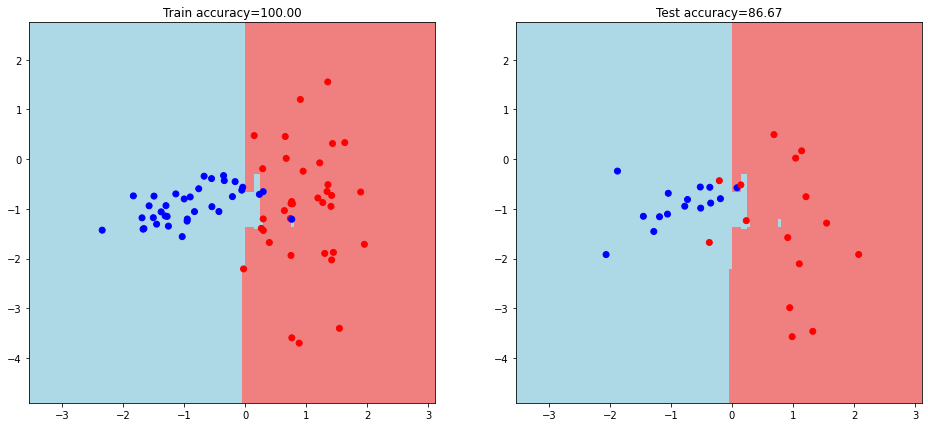

In [877]:
plot_forest(my_forest_50, train_data, test_data)

**Лес из 10 деревьев**

In [878]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [879]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [880]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571


In [881]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


In [882]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 10, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  0.9857142857142858
oob_score_ 0.8714285714285714


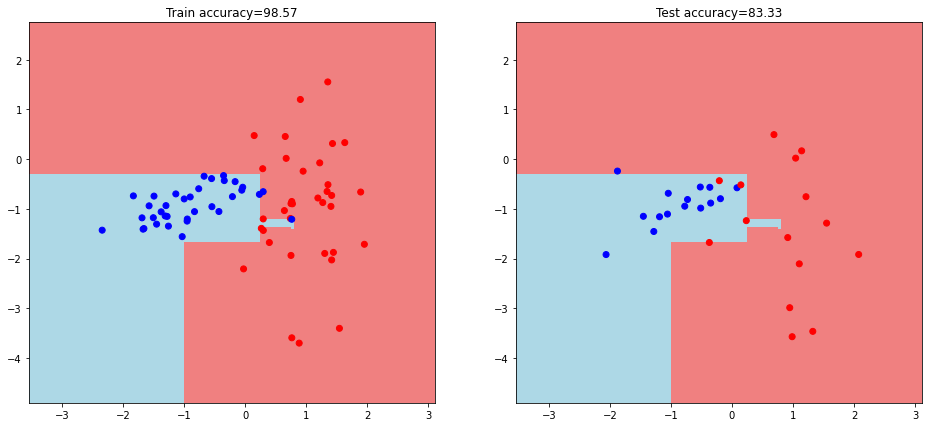

In [883]:
plot_forest(my_forest_10, train_data, test_data)

**Вывод:** Произошло переобучение. Чем больше деревьев в лесу тем сложнее гиперплоскость.

4.(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [884]:
def entropy (labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * math.log(p, 2)
        
    return impurity

In [885]:
# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [886]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [887]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [888]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [889]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [890]:
#Добавим фукцию случайного формирования леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [891]:
 #Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [892]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [893]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [894]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


In [895]:
# Визуализируем дерево на графике

def plot_forest(forest, train_data, test_data):
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [896]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [897]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [898]:
def classification_error(p):
   return 1 - np.max([p, 1 - p])

In [899]:
c_err = [classification_error(i) for i in train_data]


**Лес из одного дерева**

In [900]:
n_trees_e = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees_e)

In [901]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [902]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 95.714


In [903]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 86.667


In [904]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 1, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print(forest.oob_score_)

Score:  0.9428571428571428
0.5571428571428572


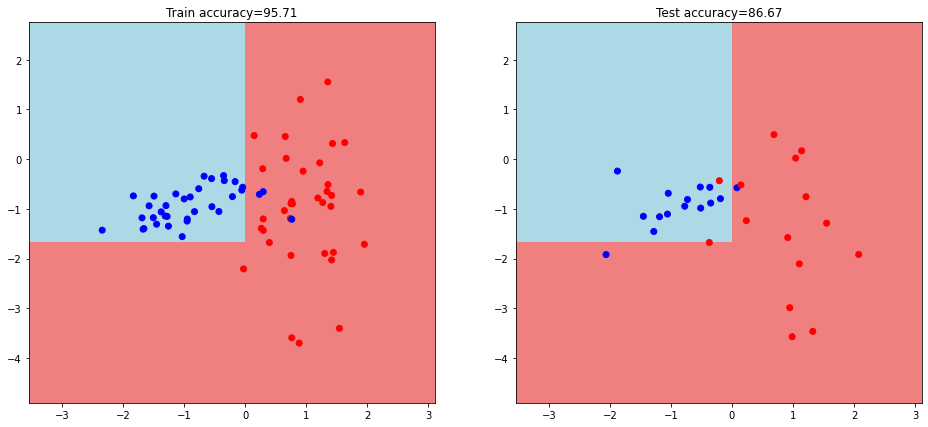

In [905]:
plot_forest(my_forest_1, train_data, test_data)

**Лес из 3-х деревьев**

In [906]:
n_trees_e = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees_e)

In [907]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [908]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.571


In [909]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 86.667


In [910]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 3, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  1.0
oob_score_ 0.8142857142857143


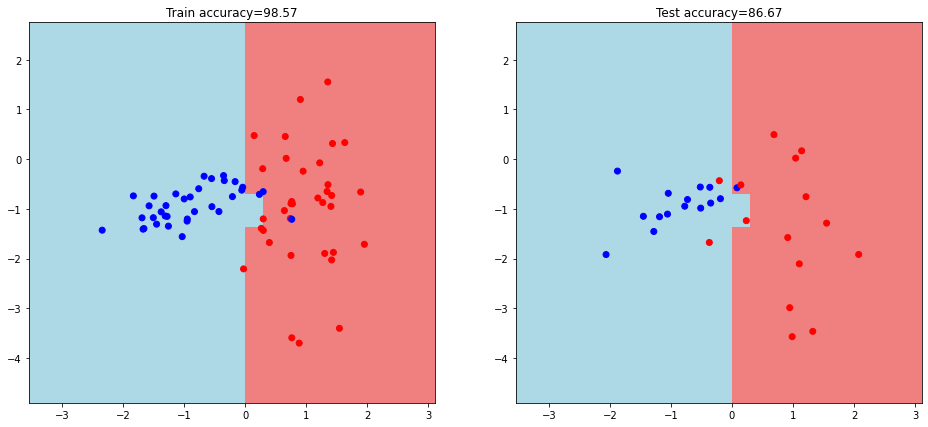

In [911]:
plot_forest(my_forest_3, train_data, test_data)

**Лес из 50 деревьев**

In [912]:
n_trees_e= 50
my_forest_50 = random_forest(train_data, train_labels, n_trees_e)

In [913]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [914]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [915]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 86.667


In [916]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 50, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  1.0
oob_score_ 0.9285714285714286


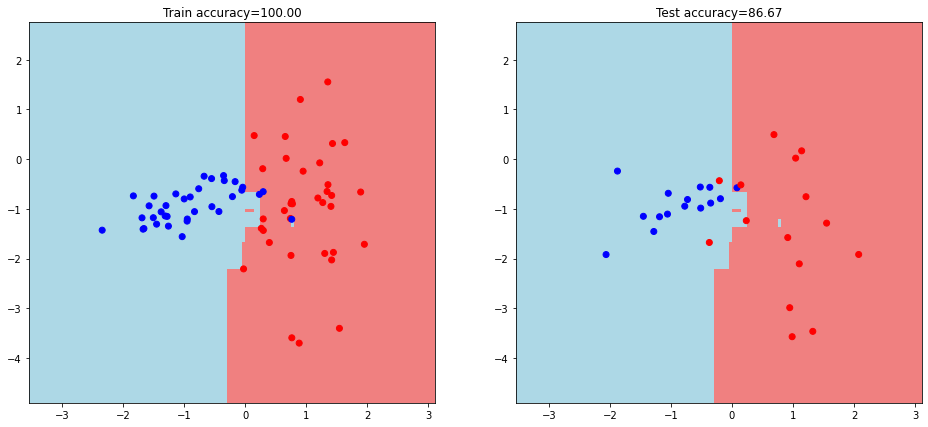

In [917]:
plot_forest(my_forest_50, train_data, test_data)

**Лес из 10 деревьев**

In [918]:
n_trees_e = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [919]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [920]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571


In [921]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees_e} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


In [922]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 10, oob_score = True)
forest.fit(train_data, train_labels)
print('Score: ', forest.score(train_data, train_labels))
print('oob_score_', forest.oob_score_)

Score:  1.0
oob_score_ 0.9285714285714286


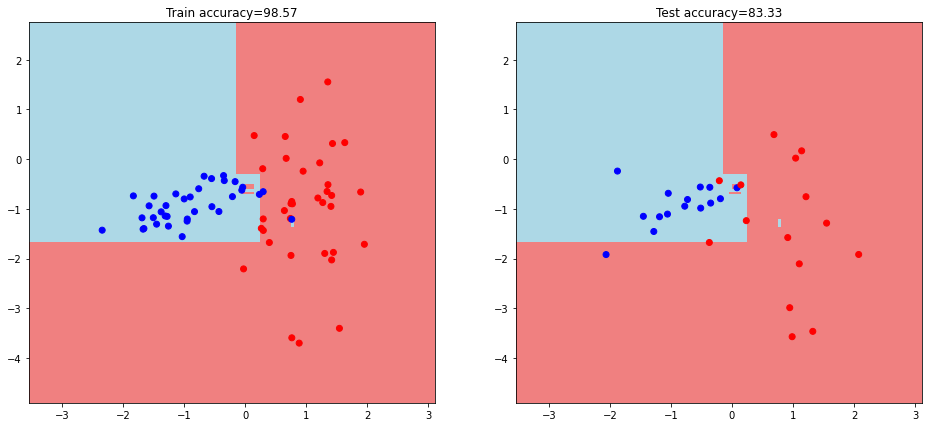

In [923]:
plot_forest(my_forest_10, train_data, test_data)

Точность RFR из 1 деревьев на трейне: 97.143
Точность RFR из 1 деревьев на тестe: 83.333
Точность RFR из 2 деревьев на трейне: 95.714
Точность RFR из 2 деревьев на тестe: 86.667
Точность RFR из 3 деревьев на трейне: 98.571
Точность RFR из 3 деревьев на тестe: 90.000
Точность RFR из 4 деревьев на трейне: 95.714
Точность RFR из 4 деревьев на тестe: 83.333
Точность RFR из 5 деревьев на трейне: 100.000
Точность RFR из 5 деревьев на тестe: 86.667
Точность RFR из 6 деревьев на трейне: 97.143
Точность RFR из 6 деревьев на тестe: 86.667
Точность RFR из 7 деревьев на трейне: 100.000
Точность RFR из 7 деревьев на тестe: 86.667
Точность RFR из 8 деревьев на трейне: 98.571
Точность RFR из 8 деревьев на тестe: 86.667
Точность RFR из 9 деревьев на трейне: 100.000
Точность RFR из 9 деревьев на тестe: 83.333
Точность RFR из 10 деревьев на трейне: 98.571
Точность RFR из 10 деревьев на тестe: 86.667
Точность RFR из 11 деревьев на трейне: 98.571
Точность RFR из 11 деревьев на тестe: 86.667
Точность RFR и

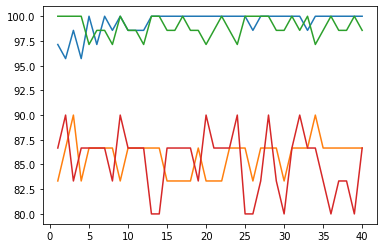

In [924]:
trx = [i for i in range(1, 41)]
tra = []
tea = []
for n_trees in trx:
    my_forest = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность RFR из {n_trees} деревьев на трейне: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность RFR из {n_trees} деревьев на тестe: {test_accuracy:.3f}')
    tra.append(train_accuracy)
    tea.append(test_accuracy)
    
plt.plot(trx, tra) 
plt.plot(trx, tea) 


trx = [i for i in range(1, 41)]
tra = []
tea = []
for n_trees in trx:
    my_forest = random_forest(train_data, train_labels, n_trees_e)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность RFR из {n_trees_e} деревьев на трейне: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность RFR из {n_trees} деревьев на тестe: {test_accuracy:.3f}')
    tra.append(train_accuracy)
    tea.append(test_accuracy)
    
plt.plot(trx, tra) 
plt.plot(trx, tea) 

**Вывод:** Расчеты слишком приближаются к данным при увеличении количества деревьев,что приводит к переобучению модели, но и слишком мало деревьев не самый лучший вариант, так как это может привести к недообучению модели. Необходимо найти разумный баланс деревьев чтобы можно было говорить о точности и целосности модели  Случайный лес менее чувствителен к гиперпараметрам.
Метод Джини оказался более эффективен, чем энтропия, с точки зрения вычислительной мощности. Джини ювелирнее для выбора лучших характеристик.

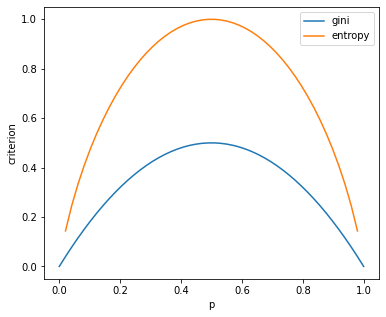

In [925]:
plt.rcParams['figure.figsize'] = (6,5)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.xlabel('p')
plt.ylabel('criterion')
plt.legend();

На графике энтропии, она сначала увеличивается до 1, а затем начинает уменьшаться, но в случае  Джини она увеличивается только до 0,5, а затем начинает уменьшаться, поэтому требуется меньше вычислительной мощности. Диапазон энтропии составляет от 0 до 1, а диапазон  Джини - от 0 до 0,5. 